In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

BASE_DIR = "/content/drive/My Drive/Colab Notebooks"
os.chdir(BASE_DIR)

print("Working directory:", os.getcwd())

Working directory: /content/drive/My Drive/Colab Notebooks


In [3]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
def load_image(path, img_rows=128, img_cols=128):
    img = Image.open(path).convert("L")
    img = ImageOps.pad(img, (img_cols, img_rows), color=0)
    return np.array(img)

# seven emotion label
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
class_to_idx = {cls: i for i, cls in enumerate(classes)}
print("Class mapping:", class_to_idx)

Class mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [5]:
MAX_IMAGES = 60
X_train_list, y_train_list = [], []

for emotion in classes:
    folder_path = os.path.join("DATASET/train", emotion)

    # only get the files with the format of .jpg, .png, .jpeg
    files = [f for f in os.listdir(folder_path)
             if f.lower().endswith((".jpg", ".png", ".jpeg"))]

    np.random.shuffle(files)

    # take first MAX_IMAGES after shuffle
    for filename in files[:MAX_IMAGES]:
        img_path = os.path.join(folder_path, filename)
        X_train_list.append(load_image(img_path))
        y_train_list.append(class_to_idx[emotion])

X_train = np.array(X_train_list, dtype="float32") / 255.0
y_train = np.array(y_train_list)

In [6]:
X_test_list, y_test_list = [], []

for emotion in classes:
    folder_path = os.path.join("DATASET/test", emotion)

    files = [f for f in os.listdir(folder_path)
             if f.lower().endswith((".jpg", ".png", ".jpeg"))]

    np.random.shuffle(files)

    for filename in files[:MAX_IMAGES]:
        img_path = os.path.join(folder_path, filename)
        X_test_list.append(load_image(img_path))
        y_test_list.append(class_to_idx[emotion])

X_test = np.array(X_test_list, dtype="float32") / 255.0
y_test = np.array(y_test_list)

In [7]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print("Train images:", X_train.shape)
print("Test images:", X_test.shape)

Train images: (420, 128, 128, 1)
Test images: (420, 128, 128, 1)


In [8]:
# Build up CNN architecture
img_rows, img_cols = 128, 128
num_classes = len(classes)

inpx = Input(shape=(img_rows, img_cols, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(inpx)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

out = Dense(num_classes, activation='softmax')(x)

# model = Model(inputs=inpx, outputs=out)
# model.compile(
#     optimizer=SGD(),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#     metrics=['accuracy']
# )

model = Model(inputs=inpx, outputs=out)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,207,943 (16.05 MB)

 Trainable params: 4,207,943 (16.05 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# to make more versions with rotation and shift
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

In [10]:
print("Training count:", len(X_train))
# model.fit(X_train, y_train, epochs=10, batch_size=8)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=8),
    epochs=50,
    validation_data=(X_test, y_test)
)

Training count: 420
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 243ms/step - accuracy: 0.1564 - loss: 1.9774 - val_accuracy: 0.1429 - val_loss: 1.9486
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 206ms/step - accuracy: 0.1319 - loss: 1.9583 - val_accuracy: 0.1405 - val_loss: 1.9452
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - accuracy: 0.1422 - loss: 1.9495 - val_accuracy: 0.1524 - val_loss: 1.9414
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.1689 - loss: 1.9399 - val_accuracy: 0.1786 - val_loss: 1.9395
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.1540 - loss: 1.9335 - val_accuracy: 0.1619 - val_loss: 1.9356
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 214ms/step - accuracy: 0.1861 - loss: 1.9208 - val_accuracy: 0.1833 - val_loss: 1.9302
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.2182 - loss: 1.9031 - val_accuracy: 0.1381 - val_loss: 2.0099
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.1840 - loss: 1.9279 - val_accuracy: 0.2024 

In [11]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {acc:.3f}")

Test accuracy: 0.302


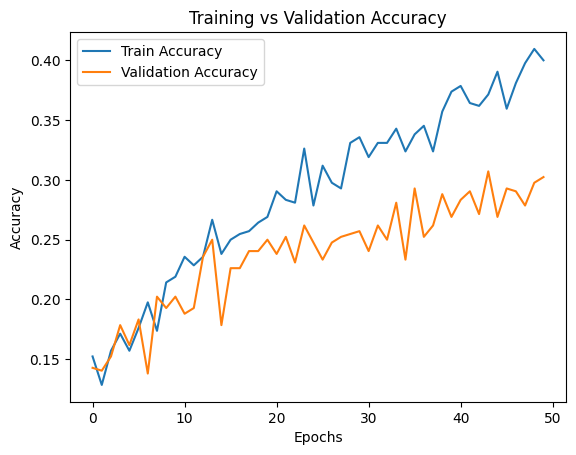

In [12]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

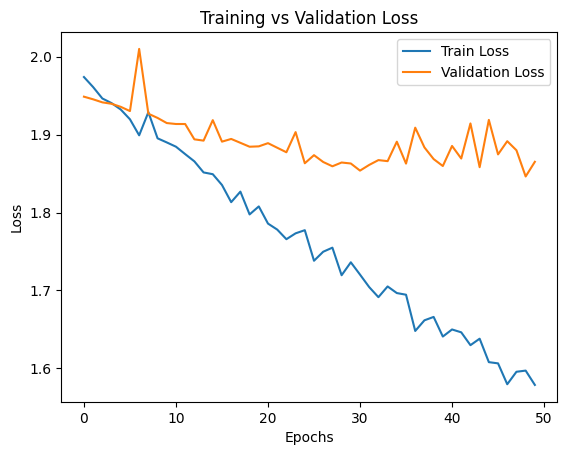

In [13]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
def convert_image_to_grayscale_with_padding(image_path, target_width=None, target_height=None):
    with Image.open(image_path) as img:
        grayscale_img = img.convert("L")

        # add padding
        if target_width and target_height:
            padded_img = ImageOps.pad(grayscale_img,
                                      (target_width, target_height),
                                      color=0)
        else:
            padded_img = grayscale_img

        grayscale_array = np.array(padded_img)

    return grayscale_array

target_h = img_rows
target_w = img_cols

print(target_h)
print(target_w)

128
128


In [15]:
test_img_path = "happy-1.jpeg"
test_img = convert_image_to_grayscale_with_padding(test_img_path,
                                                   target_w, target_h)

print("New image shape:", test_img.shape)

New image shape: (128, 128)


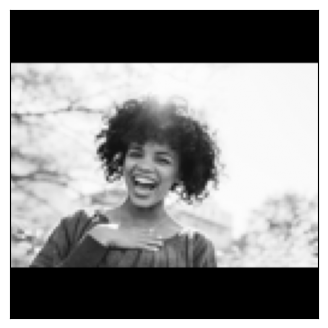

In [16]:
def plot_image(x, im_shape=(target_h, target_w)):
    plt.imshow(x.reshape(im_shape), cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.gcf().set_size_inches(4, 4)
    plt.show()

plot_image(test_img)

In [17]:
def compute_severity(pred_probs,
                     happy_neutral_surprise_threshold=0.5,
                     min_neg_score_for_severity=0.2):
    """
    Convert CNN emotion probabilities into a severity score (1–10).

    - Uses total probability of negative emotions (angry, disgust, fear, sad)
      as a simple 'negative emotion score' in [0,1].
    - If the model is clearly happy/neutral/surprise, severity = 0.
    """
    classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

    pred_idx   = int(np.argmax(pred_probs))
    pred_label = classes[pred_idx]
    pred_prob  = float(pred_probs[pred_idx])

    if pred_label in ["happy", "neutral", "surprise"] and pred_prob >= happy_neutral_surprise_threshold:
        return 0.0, 0.0

    neg_indices = [0, 1, 2, 5]
    neg_score = float(sum(pred_probs[i] for i in neg_indices))

    if neg_score < min_neg_score_for_severity:
        return 0.0, 0.0

    severity = 1 + 9 * neg_score

    return neg_score, severity

In [18]:
x_new = test_img / 255.0
x_new = x_new[np.newaxis, ..., np.newaxis]   # (1, H, W, 1)

pred_probs = model.predict(x_new)
print("Raw prediction vector:", pred_probs[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Raw prediction vector: [1.3576919e-03 6.3705695e-04 2.1664179e-03 6.3498221e-05 4.4616112e-01
 5.4954290e-01 7.1314309e-05]


In [19]:
pred_class_index = np.argmax(pred_probs[0])

classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
emotion_label = os.path.splitext(os.path.basename(test_img_path))[0].split("-")[0]
predicted_emotion = classes[pred_class_index]

print("Real Emotion:", emotion_label)
print("Predicted Emotion:", predicted_emotion)

Real Emotion: happy
Predicted Emotion: sad


In [20]:
test_img_path = "angry-1.jpg"
test_img = convert_image_to_grayscale_with_padding(test_img_path,
                                                   target_w, target_h)

x_new = test_img / 255.0
x_new = x_new[np.newaxis, ..., np.newaxis]

pred_probs = model.predict(x_new)
print("Raw prediction vector:", pred_probs[0])

pred_class_index = np.argmax(pred_probs[0])
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
emotion_label = os.path.splitext(os.path.basename(test_img_path))[0].split("-")[0]
predicted_emotion = classes[pred_class_index]

print("\nReal Emotion:", emotion_label)
print("Predicted Emotion:", predicted_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Raw prediction vector: [1.4011366e-03 9.7309740e-04 5.0846129e-03 1.6431168e-04 1.2519875e-01
 8.6667562e-01 5.0243619e-04]

Real Emotion: angry
Predicted Emotion: sad


In [21]:
test_img_path = "disgust-1.jpg"
test_img = convert_image_to_grayscale_with_padding(test_img_path,
                                                   target_w, target_h)

x_new = test_img / 255.0
x_new = x_new[np.newaxis, ..., np.newaxis]

pred_probs = model.predict(x_new)
print("Raw prediction vector:", pred_probs[0])

pred_class_index = np.argmax(pred_probs[0])
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
emotion_label = os.path.splitext(os.path.basename(test_img_path))[0].split("-")[0]
predicted_emotion = classes[pred_class_index]

print("\nReal Emotion:", emotion_label)
print("Predicted Emotion:", predicted_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Raw prediction vector: [0.0017519  0.00516408 0.01147541 0.00294051 0.9363436  0.03700316
 0.00532128]

Real Emotion: disgust
Predicted Emotion: neutral


In [22]:
test_img_path = "fear-1.jpeg"
test_img = convert_image_to_grayscale_with_padding(test_img_path,
                                                   target_w, target_h)

x_new = test_img / 255.0
x_new = x_new[np.newaxis, ..., np.newaxis]

pred_probs = model.predict(x_new)
print("Raw prediction vector:", pred_probs[0])

pred_class_index = np.argmax(pred_probs[0])
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
emotion_label = os.path.splitext(os.path.basename(test_img_path))[0].split("-")[0]
predicted_emotion = classes[pred_class_index]

print("\nReal Emotion:", emotion_label)
print("Predicted Emotion:", predicted_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Raw prediction vector: [6.3545897e-04 1.5431937e-03 4.5516817e-03 8.5499625e-05 1.8472263e-01
 8.0817527e-01 2.8626734e-04]

Real Emotion: fear
Predicted Emotion: sad


In [23]:
test_img_path = "neutral-1.jpg"
test_img = convert_image_to_grayscale_with_padding(test_img_path,
                                                   target_w, target_h)

x_new = test_img / 255.0
x_new = x_new[np.newaxis, ..., np.newaxis]

pred_probs = model.predict(x_new)
print("Raw prediction vector:", pred_probs[0])

pred_class_index = np.argmax(pred_probs[0])
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
emotion_label = os.path.splitext(os.path.basename(test_img_path))[0].split("-")[0]
predicted_emotion = classes[pred_class_index]

print("\nReal Emotion:", emotion_label)
print("Predicted Emotion:", predicted_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Raw prediction vector: [5.8164448e-04 7.2312105e-04 4.5715407e-03 8.1721788e-05 4.3493591e-02
 9.4988090e-01 6.6754525e-04]

Real Emotion: neutral
Predicted Emotion: sad


In [24]:
test_img_path = "sad-1.jpg"
test_img = convert_image_to_grayscale_with_padding(test_img_path,
                                                   target_w, target_h)

x_new = test_img / 255.0
x_new = x_new[np.newaxis, ..., np.newaxis]

pred_probs = model.predict(x_new)
print("Raw prediction vector:", pred_probs[0])

pred_class_index = np.argmax(pred_probs[0])
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
emotion_label = os.path.splitext(os.path.basename(test_img_path))[0].split("-")[0]
predicted_emotion = classes[pred_class_index]

print("\nReal Emotion:", emotion_label)
print("Predicted Emotion:", predicted_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Raw prediction vector: [8.2377339e-04 1.8006639e-04 1.7243713e-03 5.5748038e-05 3.1164475e-03
 9.9404573e-01 5.3774635e-05]

Real Emotion: sad
Predicted Emotion: sad


In [25]:
test_img_path = "surprise-1.jpg"
test_img = convert_image_to_grayscale_with_padding(test_img_path,
                                                   target_w, target_h)

x_new = test_img / 255.0
x_new = x_new[np.newaxis, ..., np.newaxis]

pred_probs = model.predict(x_new)
print("Raw prediction vector:", pred_probs[0])

pred_class_index = np.argmax(pred_probs[0])
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
emotion_label = os.path.splitext(os.path.basename(test_img_path))[0].split("-")[0]
predicted_emotion = classes[pred_class_index]

print("\nReal Emotion:", emotion_label)
print("Predicted Emotion:", predicted_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Raw prediction vector: [0.28897482 0.05871461 0.28128946 0.05206095 0.05859364 0.21864642
 0.04172004]

Real Emotion: surprise
Predicted Emotion: angry
